# Import 

In [ ]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd

import time

from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json 
from tensorflow.keras import utils

from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans 
from  sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error, mean_absolute_error

from math import sqrt

import matplotlib as plt

In [ ]:
# для загрузки данных с гугл диска в колаб
from google.colab import drive   
drive.mount('/content/drive')

# Пояснение:


в данной работе были применены разные подходы к построению рекомендательной системы. 
В первом разделе применена коллаборативная фильтрация на оценках пользователя и похожести на других пользователей, которая основана в свою очередь на показателе косинусного расстояния для пользователей и фильмов
В данном разделе рекомендации рассчитываются по трем разным формулам:
- Наивные рекомендации
- рекомендации с учетом средних оценок похожих пользователей
- Рекомендации на основе средних оценок пользователей и матрицы “похожести”
В этом разделе учитываются только пользователи и их оценки фильмов. Сами характеристики фильмов не учитываются. Для расчета оценок использовалась субъективная шкала поведения пользователя при выборе и просмотра фильма

Во втором разделе использовалась кластеризация на основе алгоритма k-mean. При этом здесь рассматривались уже фильмы в-отдельности - без учета поведения пользователей (поведение пользователей учитывается уже при определении рекомендаций)

В третьем разделе рассмотрены основные вохможности по применению нейронных сетей к данной задаче.



#  1. Коллаборативная фильтрация на оценках пользователя и похожести на других пользователей


В данном подходе основной задачей является найти похожих пользователей  и похожие фильмы  на основании оценок, которые проставили пользователи. Своими словами: Пользователи, ставящие одинаковые оценки одним и тем же фильмам -  похожи. Фильмы, которым ставят похожие оценки, - похожи. 
В первом случае подход называется User-Based коллаборативная фильтрация, во втором Item-Based коллаборативная фильтрация

In [ ]:
# загружаем дата фрейм (в зависимости от того, как работаем - в колабе или локально)
events_df = pd.read_csv('Downloads/events.csv')
# events_df = pd.read_csv('/content/drive/MyDrive/Er-telecom/events.csv')

In [ ]:
 events_df.head(20)

,subscriberid,deviceid,eventtype,assetid,platformid,ts,progressvalue,assetposition
0,74787667,77014816,31,1521417,5,1554563806,22.0,NaN
1,77129711,77741436,11,1156524,36,1554623013,NaN,56.0
2,77129711,77741436,6,1156524,36,1554623000,NaN,56.0
3,77583162,77686100,6,1659973,36,1556130743,NaN,46.0
4,34869285,41748299,6,1521433,5,1555849789,NaN,3.0
5,76924800,76925664,31,1276221,36,1555632505,75.0,182.0
6,31082325,76393733,31,1655444,36,1555509765,30.0,50.0
7,62407986,62639391,6,330381,36,1555653673,NaN,5.0
8,60813359,77830848,31,1521481,36,1555311956,1.0,9.0
9,78368236,78406793,31,1636445,36,1556016592,32.0,1.0


## 1.1. Проставление оценок фильмам

В первую очередь необходимо трансформировать имеющиеся данные о поведении пользователей в оценки фильмам.
Была применена достаточно субъективная модель выявления оценок - от самой низкой, когда пользователь ставит дизлайк фильму, до самой высшей, когда пользователь ставит лайк фильму. В остальных вариантах применялись промежуточные решения, которые в свою очередт также учитывали поведение пользватаеля. Например, ситуация, когда пользователь начал смотреть фильм и досмотрел его до конца позволяет предположить, что пользователь оценил фильм выше, чем тот, который не досмотрел и до середины.

Общая шкала оценок:
- 1 балл - пользователь поставил дизлайк
- 2 балла - пользователь купил фильм, но не досмотрел и до середины (говорит о том, что фильм не хочется сммотреть, даже несмотря на потраченные средства)
- 3 балла - клик по фильму, но без добавления в исзбранное или начало просмотра. Говорит о том, что после изучения информации о фильме, пользователь не был заинтересован
- 3 балла - польщзователь начал смотреть, но не досмотрел и до середины. Говорит о том, что фильм не смог заинтересовать
- 4 балла - посмотрел трейлер, но не начал смотреть либо начал смотреть, но не досмотрел до середины. Говорит о том, что сама тематика фильма заинтересовала, но конкретно этот фильм не впечатлил
- 5 баллов - добавил в избранное. Тематика фильма и сам фильм заинтересовали. возможно вернется к просмотру в будущем. 
- 6 баллов - Купил фильм, но не начал смотреть. Фильм интересен, однако до просмотра еще не дошло
- 7 баллов - фильм просмотрен полностью. Фильм выбран, начат смотреть и закончен. Значит пользователю интересна тематика и сам фильм 
- 10 баллов - пользователь поставил лайк 

Данная шкала субъективна и вполне может требовать более детальной проработки. Однако ее более чем достаточно для нашего первого исследования


In [ ]:
# выведем фильмы и пользователей, которые поставили лайки. Проставляем всем 10 баллов вне зависимости от другого поведения пользователей
liked = events_df[events_df['eventtype'] == 15].loc[:,['subscriberid', 'assetid']].reset_index()
liked['Rating'] = 10
liked

,index,subscriberid,assetid,Rating
0,124,77403446,1464939,10
1,154,10017410,1497669,10
2,345,4463114,1517058,10
3,445,33088656,484813,10
4,752,15921841,1521577,10
...,...,...,...,...
62232,10234597,75393230,1244711,10
62233,10234964,75393230,1069871,10
62234,10235367,13595700,1824288,10
62235,10236036,75393230,1339179,10


In [ ]:
# выведем фильмы и пользователей, которые поставили дизлайки. Проставляем всем 1 балл вне зависимости от другого поведения пользователей
disliked = events_df[events_df['eventtype'] == 16].loc[:,['subscriberid', 'assetid']].reset_index()
disliked['Rating'] = 1
disliked

,index,subscriberid,assetid,Rating
0,282,77951804,1659856,1
1,987,76511148,1114211,1
2,1269,61048828,1521593,1
3,2695,31713535,1547741,1
4,3926,75275876,1521409,1
...,...,...,...,...
5696,10222674,34227189,330311,1
5697,10223516,67838816,1636134,1
5698,10226217,34227189,1521417,1
5699,10235866,75393230,1825547,1


In [ ]:
# объединяем полученные массивы 
liked_disliked = pd.concat([liked, disliked])
liked_disliked

,index,subscriberid,assetid,Rating
0,124,77403446,1464939,10
1,154,10017410,1497669,10
2,345,4463114,1517058,10
3,445,33088656,484813,10
4,752,15921841,1521577,10
...,...,...,...,...
5696,10222674,34227189,330311,1
5697,10223516,67838816,1636134,1
5698,10226217,34227189,1521417,1
5699,10235866,75393230,1825547,1


In [ ]:
# получаем записи, когда пользователи закончили просмотр
mask = (events_df['eventtype'] == 19)
finished = events_df[mask].loc[:,['subscriberid', 'assetid']].reset_index()
finished

,index,subscriberid,assetid
0,39,507070,1521417
1,67,11775228,1525734
2,98,4593816,1483795
3,117,77601803,1528949
4,126,77403446,1464939
...,...,...,...
617615,10236673,84754719,1528940
617616,10236720,85912714,720142407
617617,10236723,8611826,720333719
617618,10236725,80691367,1521698


In [ ]:
# вычитаем записи, когда пользователи поставили лайк или дизлайк. Остаются только те, кто закончил просмотр но не поставил свою оценку
finished = finished[~finished['subscriberid'].isin(liked_disliked['subscriberid']) & ~finished['assetid'].isin(liked_disliked['assetid'])]
finished['Rating'] = 7
finished

<ipython-input-8-2660ce2e5808>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finished['Rating'] = 7


,index,subscriberid,assetid,Rating
20,408,67436636,789317,7
22,432,76536717,1132431,7
64,966,1414309,1528967,7
72,1096,43489296,1132466,7
85,1322,45918762,343469,7
...,...,...,...,...
617589,10236393,85583869,1824255,7
617592,10236438,10172809,1132473,7
617593,10236439,10172809,1132473,7
617616,10236720,85912714,720142407,7


In [ ]:
# объединяем полученные массивы
total_df = pd.concat([liked_disliked, finished])

In [ ]:
# получаем записи, когда пользователи досмотрели до середины
mask = ((events_df['eventtype'] == 31) & (events_df['progressvalue'] > 50))
half_watched = events_df[mask].loc[:,['subscriberid', 'assetid']].reset_index()
half_watched

,index,subscriberid,assetid
0,5,76924800,1276221
1,16,8385835,1091054
2,18,71251247,1339284
3,23,77171025,1525716
4,24,77171025,1525716
...,...,...,...
1989160,10236746,75075548,462827
1989161,10236750,24731784,719823814
1989162,10236751,24731784,719823814
1989163,10236753,85652267,1314497


In [ ]:
# вычитаем предыдущие значения, чтобы отсечь тех, кто досмотрел до середины и потом до конца
half_watched = half_watched[~half_watched['subscriberid'].isin(total_df['subscriberid']) & ~half_watched['assetid'].isin(total_df['assetid'])]
half_watched['Rating'] = 4
half_watched

<ipython-input-11-737bfe276310>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  half_watched['Rating'] = 4


,index,subscriberid,assetid,Rating
6976,29435,79659656,661261714,4
7257,30351,77675466,667043824,4
7468,30962,79634732,669476263,4
8692,35234,78855028,669795901,4
9130,36816,80195197,660968752,4
...,...,...,...,...
1987082,10225680,81709502,674403837,4
1987086,10225708,80452456,671703665,4
1987188,10226114,81973955,681901217,4
1987260,10226394,80452456,671703665,4


In [ ]:
# объединяем полученные массивы
total_df = pd.concat([total_df, half_watched])

In [ ]:
# получаем записи, когда пользователи купили фильм
mask = (events_df['eventtype'] == 11)
bought = events_df[mask].loc[:,['subscriberid', 'assetid']].reset_index()
bought

,index,subscriberid,assetid
0,1,77129711,1156524
1,90,77978871,1300112
2,148,76843214,1133130
3,220,77121729,333466
4,278,9664643,171182
...,...,...,...
41463,10235497,68781758,333466
41464,10235519,86689048,312172
41465,10236348,78701396,302451
41466,10236489,86520285,1781314


In [ ]:
# получаем записи, когда пользователи начали смотреть фильм
mask = (events_df['eventtype'] == 10)
started = events_df[mask].loc[:,['subscriberid', 'assetid']].reset_index()
started

,index,subscriberid,assetid
0,11,75233036,795588
1,38,67246999,1659730
2,56,76883430,462589
3,63,76924800,1474439
4,77,77301674,1650404
...,...,...,...
742677,10236736,86949099,1659739
742678,10236739,86949099,1523196
742679,10236741,86949099,1521529
742680,10236747,75075548,462827


In [ ]:
# делаем копии предыдущих двух массивов
started_copy = started.copy()
bought_copy = bought.copy()

In [ ]:
# вычитываем из массива купивших всех начал смотреть фильм, а также все предыдущие массивы. Получаем только тех, кто купил и не начал смотреть
bought = bought_copy[~bought_copy['subscriberid'].isin(started_copy['subscriberid']) & ~bought_copy['assetid'].isin(started_copy['assetid'])]
bought = bought_copy[~bought_copy['subscriberid'].isin(total_df['subscriberid']) & ~bought_copy['assetid'].isin(total_df['assetid'])]

bought['Rating'] = 6
bought

<ipython-input-16-f85547fef49b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bought['Rating'] = 6


,index,subscriberid,assetid,Rating
32,17217,78644429,885791,6
64,34231,62194590,885791,6
195,123092,67798403,333466,6
248,158063,77974857,543824,6
291,176302,78230115,543824,6
...,...,...,...,...
41419,10221112,80313161,566829,6
41421,10221237,82047919,566829,6
41422,10221303,82246425,885791,6
41442,10230291,78332525,566829,6


In [ ]:
# выычитаем купивших фильм и все предыдущие массивы. Получаем только тех, кто начал смотреть и ничего более
started = started_copy[~started_copy['subscriberid'].isin(bought_copy['subscriberid']) & ~started_copy['assetid'].isin(bought_copy['assetid'])]
started = started_copy[~started_copy['subscriberid'].isin(total_df['subscriberid']) & ~started_copy['assetid'].isin(total_df['assetid'])]

started['Rating'] = 3
started

<ipython-input-17-78ce6d09ee0b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  started['Rating'] = 3


,index,subscriberid,assetid,Rating
51,480,2497988,1506065,3
249,2689,11031857,334453,3
331,3704,78395040,570930,3
390,4353,73908535,792873,3
417,4629,76893983,815658,3
...,...,...,...,...
739032,10191681,85188485,563594,3
739642,10199864,38809938,347693,3
740608,10211224,965716,1133790,3
741362,10220497,89829183,768689,3


In [ ]:
# смотреим пересечение массивов купивших и начавших смотреть. Вычитаем предыдущие массивы Получаем тех кто купил, начал смотреть и не досмотрел и до середины
started_bought = pd.merge(started_copy, bought_copy, how='inner', on=['subscriberid','assetid'])
started_bought = started_bought[~started_bought['subscriberid'].isin(total_df['subscriberid']) & ~started_bought['assetid'].isin(total_df['assetid'])]
started_bought['Rating'] = 2
started_bought

,index_x,subscriberid,assetid,index_y,Rating
5253,446929,91862139,1797857,446928,2
5815,464064,79811055,815658,7417324,2
9376,827210,74549868,1879609,2552156,2
12611,1131146,55887658,331633,1131145,2
12612,1131146,55887658,331633,2499001,2
17090,1664273,91783422,792936,3630377,2
17995,1822556,93715694,487966,1822143,2
26974,3543081,87677133,1679395,3543080,2
28545,3815936,35141165,1269982,2829264,2
28687,3857179,80301181,331065,5011461,2


In [ ]:
# объединяем полученные массивы
total_df = pd.concat([total_df, started, started_bought, bought])

In [ ]:
# получаем записи, когда пользователи кликнули по фильму
mask = (events_df['eventtype'] == 6)
click = events_df[mask].loc[:,['subscriberid', 'assetid']].reset_index()
click

,index,subscriberid,assetid
0,2,77129711,1156524
1,3,77583162,1659973
2,4,34869285,1521433
3,7,62407986,330381
4,12,76385471,1256238
...,...,...,...
3918363,10236740,86949099,1521529
3918364,10236742,87355331,1014493
3918365,10236745,85410011,1537850
3918366,10236749,82922559,1821590


In [ ]:
# вычитываем предыдущие массивы, получая только клинкувших и не более
click = click[~click['subscriberid'].isin(total_df['subscriberid']) & ~click['assetid'].isin(total_df['assetid'])]
click['Rating'] = 3
click

<ipython-input-21-41fec5b8a57f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  click['Rating'] = 3


,index,subscriberid,assetid,Rating
115,362,78261794,337484,3
323,999,78228917,1155453,3
489,1535,77163591,1647932,3
1393,4465,54226362,1256364,3
1716,5491,32335170,1045888,3
...,...,...,...,...
3915657,10230613,9400932,351074,3
3916137,10231639,87768818,1826133,3
3916186,10231740,4241359,1826133,3
3917019,10233713,27317867,1276973,3


In [ ]:
# объединяем предыдущие массивы
total_df = pd.concat([total_df, click])

In [ ]:
# получаем записи, когда пользователи добавляют в избранное
mask = (events_df['eventtype'] == 5)
favorite = events_df[mask].loc[:,['subscriberid', 'assetid']].reset_index()
favorite

,index,subscriberid,assetid
0,33,9430164,1242044
1,441,33088656,1279357
2,442,33088656,1279350
3,448,33088656,1285293
4,450,33088656,1279371
...,...,...,...
46489,10235184,84415249,543943
46490,10235572,86986080,317093
46491,10235574,86986080,1697356
46492,10236487,86520285,1781314


In [ ]:
# вычитываем предыдущие массивы и получаем добавивших в избранное и не более
favorite = favorite[~favorite['subscriberid'].isin(total_df['subscriberid']) & ~favorite['assetid'].isin(total_df['assetid'])]
favorite['Rating'] = 5
favorite

<ipython-input-24-20ce26eb6b55>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  favorite['Rating'] = 5


,index,subscriberid,assetid,Rating
1178,173607,28159044,1528985,5
1784,323451,73341843,581544,5
6897,1392609,23982355,1336337,5
6898,1392610,23982355,1336939,5
36149,7937556,21743604,1235274,5


In [ ]:
# объединяем с предыдущими массивами
total_df = pd.concat([total_df, favorite])

In [ ]:
# получаем записи, когда пользователи смотрели трейлеры
mask = (events_df['eventtype'] == 34)
trailer = events_df[mask].loc[:,['subscriberid', 'assetid']].reset_index()
trailer

,index,subscriberid,assetid
0,193836,15155958,1728736
1,258737,6086957,1709601
2,261692,22288311,1731052
3,269527,32785465,1709488
4,274476,71876255,1521409
...,...,...,...
127395,10236259,74772232,1823213
127396,10236277,81806568,1659856
127397,10236279,81806568,1659901
127398,10236287,228263,1650323


In [ ]:
# вычитываем предыдущие массивы, и получаем посмотревших трейлеры и не более
trailer = trailer[~trailer['subscriberid'].isin(total_df['subscriberid']) & ~trailer['assetid'].isin(total_df['assetid'])]
trailer['Rating'] = 4
trailer

<ipython-input-27-252974b931e7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trailer['Rating'] = 4


,index,subscriberid,assetid,Rating
118,439179,10379163,1760797,4
1274,514737,12154170,1887966,4
2833,721306,75806215,1760797,4
3661,770338,36634159,262824,4
3914,787236,17965533,1611306,4
...,...,...,...,...
126047,10126014,25233510,1823361,4
126248,10143577,82842502,1823361,4
126446,10159357,18444879,1833267,4
127048,10202950,14318988,405947,4


In [ ]:
# объединяем все массивы
total_df = pd.concat([total_df, trailer])

In [ ]:
# получаем массив, в котором отражены пользователи, фильмы и их оценки фильмам
total_df

,index,subscriberid,assetid,Rating,index_x,index_y
0,124.0,77403446,1464939,10,NaN,NaN
1,154.0,10017410,1497669,10,NaN,NaN
2,345.0,4463114,1517058,10,NaN,NaN
3,445.0,33088656,484813,10,NaN,NaN
4,752.0,15921841,1521577,10,NaN,NaN
...,...,...,...,...,...,...
126047,10126014.0,25233510,1823361,4,NaN,NaN
126248,10143577.0,82842502,1823361,4,NaN,NaN
126446,10159357.0,18444879,1833267,4,NaN,NaN
127048,10202950.0,14318988,405947,4,NaN,NaN


In [ ]:
# смотрим распределение по оценкам. Видим, что пользователей, поставивших лайки больше всего
total_df.groupby('Rating').count()

,index,subscriberid,assetid,index_x,index_y
Rating,,,,,
1,5701,5701,5701,0,0
2,0,41,41,41,41
3,15471,15471,15471,0,0
4,2335,2335,2335,0,0
5,5,5,5,0,0
6,3556,3556,3556,0,0
7,27671,27671,27671,0,0
10,62237,62237,62237,0,0


In [ ]:
total_df_copy = total_df.copy()

In [ ]:
# чистим лишние столбцы
total_df.drop(labels=['index', 'index_x', 'index_y'], inplace=True, axis=1)

In [ ]:
total_df

,subscriberid,assetid,Rating
0,77403446,1464939,10
1,10017410,1497669,10
2,4463114,1517058,10
3,33088656,484813,10
4,15921841,1521577,10
...,...,...,...
126047,25233510,1823361,4
126248,82842502,1823361,4
126446,18444879,1833267,4
127048,14318988,405947,4


In [ ]:
total_df.drop_duplicates(['subscriberid', 'assetid', 'Rating'], inplace=True)

## 1.2. Косинусное расстояние для пользователей и фильмов 

In [ ]:
# посчитаем количество уникальных пользователей и фильмов
n_users = len(total_df['subscriberid'].unique())
n_movies = len(total_df['assetid'].unique())
(n_users, n_movies)

(41614, 30285)

In [ ]:
# для удобства пересчитаем айди фильмов и пользователей от 1 до n
movie_ids = total_df['assetid'].unique()

def scale_movie_id(movie_id):
    scaled = np.where(movie_ids == movie_id)[0][0] + 1
    return scaled

total_df['assetid'] = total_df['assetid'].apply(scale_movie_id)
total_df.head()

,subscriberid,assetid,Rating
0,77403446,1,10
1,10017410,2,10
2,4463114,3,10
3,33088656,4,10
4,15921841,5,10


In [ ]:
users_id = total_df['subscriberid'].unique()

def scale_user_id(user_id):
    scaled = np.where(users_id == user_id)[0][0] + 1
    return scaled

total_df['subscriberid'] = total_df['subscriberid'].apply(scale_user_id)
total_df.head()

,subscriberid,assetid,Rating
0,1,1,10
1,2,2,10
2,3,3,10
3,4,4,10
4,5,5,10


In [ ]:
# разделим выборку на обучающую и проверочную выборки
train_data, test_data = train_test_split(total_df, test_size=0.2)

print('Train shape: {}'.format(train_data.shape))
print('Test shape: {}'.format(test_data.shape))


Train shape: (82821, 3)
Test shape: (20706, 3)


In [ ]:
# проверяем есть ли нулевые значения в итоговой выборке
total_df_copy[total_df_copy['Rating'].isna()]

,index,subscriberid,assetid,Rating,index_x,index_y


In [ ]:
total_df['Rating'].unique()

array([10,  1,  7,  4,  3,  2,  6,  5], dtype=int64)

In [ ]:
# проверяем, что выборка была разеделена пропорционально для каждой из оценки, чтобы не было дисбаланса базы
for rate in total_df['Rating'].unique():
  print(train_data.groupby('Rating').count().loc[rate,:][0] / total_df.groupby('Rating').count().loc[rate,:][0])

0.799644211245081
0.8020753266717909
0.8014682155534043
0.830739299610895
0.7922012758942011
0.7727272727272727
0.8190672963400236
1.0


In [ ]:
# Для определения качества предсказанных оценок воспользуемся мерой RMSE
def rmse(prediction, ground_truth):
    # Оставим оценки, предсказанные алгоритмом, только для соотвествующего набора данных
    prediction = np.nan_to_num(prediction)[ground_truth.nonzero()].flatten()
    # Оставим оценки, которые реально поставил пользователь, только для соотвествующего набора данных
    ground_truth = np.nan_to_num(ground_truth)[ground_truth.nonzero()].flatten()
    
    mse = mean_squared_error(prediction, ground_truth)
    return sqrt(mse)

In [ ]:
# Для определения качества предсказанных оценок воспользуемся мерой MAE
def mae(prediction, ground_truth):
    # Оставим оценки, предсказанные алгоритмом, только для соотвествующего набора данных
    prediction = np.nan_to_num(prediction)[ground_truth.nonzero()].flatten()
    # Оставим оценки, которые реально поставил пользователь, только для соотвествующего набора данных
    ground_truth = np.nan_to_num(ground_truth)[ground_truth.nonzero()].flatten()
    
    return mean_absolute_error(prediction, ground_truth)
    # return sqrt(mse)

In [ ]:
# Сформируем матрицы размера (n_users, n_movies) для обучающего и тестового наборов таким образом,
#  чтобы элемент в ячейке [i, j] отражал оценку i-го пользователя j-му фильму:
train_data_matrix = np.zeros((n_users, n_movies), dtype='int8')

In [ ]:
for line in train_data.itertuples():
    train_data_matrix[line[1] - 1, line[2] - 1] = line[3]

In [ ]:
test_data_matrix = np.zeros((n_users, n_movies), dtype='int8')


In [ ]:
for line in test_data.itertuples():
    test_data_matrix[line[1] - 1, line[2] - 1] = line[3]

In [ ]:
train_data_matrix[:20]

array([[ 1,  0,  0, ...,  0,  0,  0],
       [ 0, 10,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int8)

In [ ]:
# считаем косинусное расстояние для пользователей и фильмов 
# (построчно и поколоночно соотвественно).
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [ ]:
user_similarity

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [ ]:
np.unique(user_similarity[:2])

array([0.        , 0.42264973, 0.42551501, 0.59175171, 0.59209149,
       0.66666667, 0.71132487, 0.71156513, 0.74180111, 0.75402191,
       0.76449391, 0.76488544, 0.78178211, 0.78193781, 0.79587585,
       0.79604575, 0.79630021, 0.79655373, 0.79933555, 0.80754991,
       0.81742581, 0.81757777, 0.81760811, 0.81769906, 0.83347205,
       0.83361065, 0.84569665, 0.84582508, 0.84593508, 0.85578256,
       0.85587262, 0.85605221, 0.86001316, 0.8640305 , 0.86410585,
       0.86410597, 0.871008  , 0.87107245, 0.8711368 , 0.87120106,
       0.87555319, 0.87560103, 0.87701096, 0.88214887, 0.88224696,
       0.88229599, 0.88686654, 0.88782516, 0.89098187, 0.89278875,
       0.89802287, 0.89805473, 0.8997179 , 0.90109674, 0.90414748,
       0.90641937, 0.90644399, 0.91098707, 0.91315196, 0.9149452 ,
       0.91496368, 0.91667862, 0.92907213, 0.93294025, 0.9330036 ,
       0.93472419, 0.94288138, 0.94409064, 0.95920915, 0.95927685,
       0.97115651, 0.97122835, 0.97586594, 0.97648854, 0.97819

In [ ]:
np.unique(item_similarity[:2])

array([0.        , 0.42264973, 0.42551501, 0.42833805, 0.59175171,
       0.59276852, 0.59377777, 0.66666667, 0.66722084, 0.66777225,
       0.66832094, 0.6913933 , 0.71132487, 0.71168503, 0.71204386,
       0.71240135, 0.72270322, 0.73509353, 0.73693318, 0.74180111,
       0.74205892, 0.74231596, 0.74257224, 0.76429774, 0.76449391,
       0.7646896 , 0.76488479, 0.78178211, 0.78193781, 0.78209318,
       0.79587585, 0.79600331, 0.79613053, 0.79625751, 0.79638426,
       0.80392157, 0.80489467, 0.80754991, 0.80765674, 0.80776339,
       0.80786986, 0.80797616, 0.81398367, 0.81742581, 0.81751703,
       0.81760811, 0.81778987, 0.81788055, 0.82264039, 0.82592234,
       0.82600142, 0.82615924, 0.82631663, 0.83164124, 0.83333333,
       0.83340273, 0.83347205, 0.83354128, 0.83987185, 0.8399334 ,
       0.83999488, 0.84005629, 0.84569665, 0.84575173, 0.84591661,
       0.8509288 , 0.85097847, 0.8518844 , 0.85566243, 0.85570752,
       0.85997199, 0.86001316, 0.86005429, 0.86013644, 0.86021

## 1.3. Наивные рекомендации

Для начала применим наивные рекомендации, когдапредсказываемая оценка фильму i пользователя u равняется средней оценке фильма i от N пользователей, наиболее похожих на пользователя u.

In [ ]:
# User-based collaborative filtering
def naive_predict(top):
    # Структура для хранения для каждого пользователя оценки фильмов top наиболее похожих на него пользователей:
    # top_similar_ratings[0][1] - оценки всех фильмов одного из наиболее похожих пользователей на пользователя с ид 0.
    # Здесь 1 - это не ид пользователя, а просто порядковый номер.
    top_similar_ratings = np.zeros((n_users, top, n_movies), dtype='int8')

    for i in range(n_users):
        # Для каждого пользователя необходимо получить наиболее похожих пользователей:
        # Нулевой элемент не подходит, т.к. на этом месте находится похожесть пользователя самого на себя
        top_sim_users = user_similarity[i].argsort()[1:top + 1]
        
        # берём только оценки из "обучающей" выборки 
        top_similar_ratings[i] = train_data_matrix[top_sim_users]

    pred = np.zeros((n_users, n_movies),  dtype='float16')
    for i in range(n_users):
        pred[i] = top_similar_ratings[i].sum(axis=0) / top
    
    return pred


def naive_predict_item(top):
    top_similar_ratings = np.zeros((n_movies, top, n_users), dtype='int8')

    for i in range(n_movies):
        top_sim_movies = item_similarity[i].argsort()[1:top + 1]
        top_similar_ratings[i] = train_data_matrix.T[top_sim_movies]
        
    pred = np.zeros((n_movies, n_users), dtype='float16')
    for i in range(n_movies):
        pred[i] = top_similar_ratings[i].sum(axis=0) / top
    
    return pred.T


In [ ]:
# рассчитаем показатель ошибки User-based для тестовой базы использую параметр 7 ближайших пользователей
naive_pred = naive_predict(7)
print('User-based CF RMSE: ', rmse(naive_pred, test_data_matrix))

User-based CF RMSE:  8.177713616898062


In [ ]:
del naive_pred

In [ ]:
# рассчитаем показатель ошибки Item-based для тестовой базы использую параметр 7 ближайших пользователей
naive_pred_item = naive_predict_item(7)
print('Item-based CF RMSE: ', rmse(naive_pred_item, test_data_matrix))


Item-based CF RMSE:  8.116341540373963


In [ ]:
del naive_pred_item

In [ ]:
# аналогичные показатель по МАЕ
naive_pred = naive_predict(7)
print('User-based CF MAE: ', mae(naive_pred, test_data_matrix))

User-based CF MAE:  7.637


In [ ]:
naive_pred_item = naive_predict_item(7)
print('Item-based CF MAE: ', mae(naive_pred_item, test_data_matrix))


Item-based CF MAE:  7.58


## 1.4. Рекомендации с учётом средних оценок похожих пользователей

Менее наивная реализация требует участия матрицы “похожести” и оценок “похожих” пользователей. То есть предсказываемая оценка фильму будет равна сумме произведений “похожести” пользователя на его оценку по всем наиболее похожим пользователям.



In [ ]:
def k_fract_predict(top):
    top_similar = np.zeros((n_users, top), dtype='float16')
    
    for i in range(n_users):
        user_sim = user_similarity[i]
        top_sim_users = user_sim.argsort()[1:top + 1]#[-top:]

        for j in range(top):
            top_similar[i, j] = top_sim_users[j]
            
    abs_sim = np.abs(user_similarity)
    pred = np.zeros((n_users, n_movies), dtype='float16')
    
    for i in range(n_users):
        indexes = top_similar[i].astype(np.int)
        numerator = user_similarity[i][indexes]
        
        product = numerator.dot(train_data_matrix[indexes])
        
        denominator = abs_sim[i][top_similar[i].astype(np.int)].sum()
        
        pred[i] = product / denominator
    
    return pred


def k_fract_predict_item(top):
    flag = True
    top_similar = np.zeros((n_movies, top), dtype='float16')
    
    for i in range(n_movies):
        movies_sim = item_similarity[i]
        top_sim_movies = movies_sim.argsort()[1:top + 1]

        for j in range(top):
            top_similar[i, j] = top_sim_movies.T[j]
            
    abs_sim = np.abs(item_similarity)
    pred = np.zeros((n_movies, n_users), dtype='float16')
    
    
    for i in range(n_movies):
        indexes = top_similar[i].astype(np.int)
        numerator = item_similarity[i][indexes]
        
        product = numerator.dot(train_data_matrix.T[indexes])
        
        denominator = abs_sim[i][indexes].sum()
        denominator = denominator if denominator != 0 else 1
        
        pred[i] = product / denominator
        
    return pred.T


Рассчитываем аналогичные первому подходу показатели RMSE и MAE

In [ ]:

k_predict = k_fract_predict(7)
print('User-based CF RMSE: ', rmse(k_predict, test_data_matrix))

<ipython-input-60-b49d489535e2>:22: RuntimeWarning: invalid value encountered in true_divide
  pred[i] = product / denominator


User-based CF RMSE:  8.200609733428363


In [ ]:
print('User-based CF MAE: ', mae(k_predict, test_data_matrix))

User-based CF MAE:  7.664


In [ ]:
del k_predict

In [ ]:
k_predict_item = k_fract_predict_item(7)
print('Item-based CF RMSE: ', rmse(k_predict_item, test_data_matrix))

Item-based CF RMSE:  8.104782538723663


In [ ]:
print('Item-based CF mae: ', mae(k_predict_item, test_data_matrix))

Item-based CF mae:  7.543


In [ ]:
del k_predict_item

## 1.5. Рекомендации на основе средних оценок пользователей и матрицы “похожести”

Третья реализация зависит от оценок, которые пользователь ставил ранее (точнее, от средней оценки по всем оценённым пользователем фильмам), средних оценок “похожих” пользователей и коэффициентов “похожести”

In [ ]:
def k_fract_mean_predict(top):
    top_similar = np.zeros((n_users, top), dtype='float16')
    
    for i in range(n_users):
        user_sim = user_similarity[i]
        top_sim_users = user_sim.argsort()[1:top + 1]

        for j in range(top):
            top_similar[i, j] = top_sim_users[j]
            
    abs_sim = np.abs(user_similarity)
    pred = np.zeros((n_users, n_movies), dtype='float16')
    
    for i in range(n_users):
        indexes = top_similar[i].astype(np.int)
        numerator = user_similarity[i][indexes]
        
        mean_rating = np.array([x for x in train_data_matrix[i] if x > 0]).mean()
        diff_ratings = train_data_matrix[indexes] - train_data_matrix[indexes].mean()
        numerator = numerator.dot(diff_ratings)
        denominator = abs_sim[i][top_similar[i].astype(np.int)].sum()
        
        pred[i] = mean_rating + numerator / denominator
        
    return pred

def k_fract_mean_predict_item(top):
    top_similar = np.zeros((n_movies, top), dtype='float16')
    
    for i in range(n_movies):
        movie_sim = item_similarity[i]
        top_sim_movies = movie_sim.argsort()[1:top + 1]
        
        for j in range(top):
            top_similar[i, j] = top_sim_movies[j]
    
    abs_sim = np.abs(item_similarity)
    pred = np.zeros((n_movies, n_users), dtype='float16')
    
    for i in range(n_movies):
        indexes = top_similar[i].astype(np.int)
        numerator = item_similarity[i][indexes]
        
        diff_ratings = train_data_matrix.T[indexes] - train_data_matrix.T[indexes].mean()
        numerator = numerator.dot(diff_ratings)
        denominator = abs_sim[i][top_similar[i].astype(np.int)].sum()
        denominator = denominator if denominator != 0 else 1
        
        mean_rating = np.array([x for x in train_data_matrix.T[i] if x > 0]).mean()
        mean_rating = 0 if np.isnan(mean_rating) else mean_rating
        pred[i] = mean_rating + numerator / denominator
                
    return pred.T



Рассчитываем аналогичные показатели RMSE и MAE

In [ ]:

k_predict = k_fract_mean_predict(7)
print('User-based CF RMSE: ', rmse(k_predict, test_data_matrix))

<ipython-input-67-9c0e2bb5ff5d>:18: RuntimeWarning: Mean of empty slice.
  mean_rating = np.array([x for x in train_data_matrix[i] if x > 0]).mean()
C:\Users\Vlaso\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-67-9c0e2bb5ff5d>:23: RuntimeWarning: invalid value encountered in true_divide
  pred[i] = mean_rating + numerator / denominator


User-based CF RMSE:  4.421184795956848


In [ ]:
print('User-based CF MAE: ', mae(k_predict, test_data_matrix))

User-based CF MAE:  2.518


In [ ]:
del k_predict

In [ ]:
k_predict_item = k_fract_mean_predict_item(7)
print('Item-based CF RMSE: ', rmse(k_predict_item, test_data_matrix))

<ipython-input-67-9c0e2bb5ff5d>:49: RuntimeWarning: Mean of empty slice.
  mean_rating = np.array([x for x in train_data_matrix.T[i] if x > 0]).mean()
C:\Users\Vlaso\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Item-based CF RMSE:  3.8446391248074248


In [ ]:
print('Item-based CF MAE: ', mae(k_predict_item, test_data_matrix))

Item-based CF MAE:  2.266


## Выводы по разделу 1

Итоговые оценки:
- наивные рекомендации
  - User-based
    - RMSE - 8.18
    - MAE -  8.12
  - Content-based
    - RMSE - 7.63
    - MAE -  7.58

- Рекомендации с учетом средних оценок похоэих пользователей
  - User-based
    - RMSE - 8.2
    - MAE - 7.66
  - Content-based
    - RMSE - 8.1
    - MAE -  7.54

- рекомендации на основе средних оценок пользователей и матрицы похожести
  - User-based
    - RMSE - 4.42
    - MAE - 2.52
  - Content-based
    - RMSE - 3.85
    - MAE -  2.27

  Лучшие результаты были достигнуты при использовании самой сложной методики на основе средних оценок пользователей и матрицы похожести.
  Показатель МАЕ = 2.2 на мой взгляд является приемлимым для практического применения с учетом 10 балльной системы оценки.

  попробуем применить альтернативные подходы к кластеризации данных

# 2. Кластеризация фильмов на основе k-mean

В данном подходе вся база фильмов переводится в многомерный вектор на основании имеющейся инфомрации. Далее фильмы объединяются в кластеры на основании средних рассмотяний до центров кластеров.
Система рекомендации в таком случае может строиться следующим образом: пользователю рекомендуется фильм, который входит в тот же кластер, что и фильм, которому пользователь поставил лайк/купил/добавил в избранное

In [ ]:
# считаем данные
movies_df = pd.read_csv('Downloads/movie_meta.csv')

In [ ]:
movies_df

,nativeitemid,title,duration,numberoscarawards,numberemmyawards,year,categorynames,countryname,ishd,description,agerating,kinopoiskrating,imdbrating,genretitles,rolenames,personnames,refbooktitles,refbooktypes
0,2040089,Груз 300,4563,0,0,599616000,Фильмы,СССР,SD,"1986 год, Афганистан. Геологическая экспедиция...",R18,0.00,0.0,"Военные,Драмы",NaN,NaN,NaN,NaN
1,1069541,Это моя собака,5400,0,0,1325376000,Фильмы,Россия,SD,После пяти лет ожидания решительных действий о...,R12,0.00,0.0,Драмы,NaN,NaN,NaN,NaN
2,1870538,Один король — одна Франция UHD,7314,0,0,1514764800,"Фильмы,Фильмы в формате UHD",Бельгия,SD,События происходят во времена Великой французс...,R16,0.00,0.0,Драмы,NaN,NaN,NaN,NaN
3,2042300,Другой (Сурдоперевод),5200,0,0,1546300800,"Фильмы,Фильмы с сурдопереводом",Бельгия,SD,Мать-одиночка Сара переезжает с ребенком в нов...,R18,0.00,0.0,"Драмы,Ужасы",NaN,NaN,NaN,NaN
4,2043745,Невеста пугала,5377,0,0,1546300800,Фильмы,Великобритания,SD,"Оставшись без работы, Мэй падает духом. Неожид...",R18,0.00,0.0,"Драмы,Ужасы",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187,1310367,Белль и Себастьян: Друзья навек,5237,0,0,1483228800,Фильмы,Франция,HD,"Прошло два года после событий, описанных во вт...",R6,6.72,6.2,Приключения,"Актёр,Актёр,Актёр,Актёр,Актёр,Актёр,Актёр,Актё...","Феликс Боссюе,Чеки Карио,Кловис Корнийяк,Ть...","русский,злодей,дружба,настоящая дружба,Дети и ...","1,2,2,7,2,8,2,8,8,7,9,11,8,3,8"
12188,1329708,Евротур,5410,0,0,1072915200,NaN,"США, Чехия",HD,"Скотт Томас — выпускник местной школы, котором...",R16,7.56,6.6,Комедии,"Актёр,Актёр,Актёр,Актёр,Актёр,Режиссёр,Режиссё...","Скотт Мехловиц,Джекоб Питтс,Кристин Крук,Кэ...","наши дни,любовь,Paramount,дружба,веселые прикл...","4,7,8,7,7,3,2,2,2,3,7"
12189,1467588,Не чужие,4680,0,0,1514764800,NaN,Россия,HD,В русской глубинке жизнь словно застыла в 90-х...,R16,5.78,0.0,Драмы,"Актёр,Актёр,Актёр,Актёр,Актёр,Актёр,Актёр,Актё...","Татьяна Владимирова,Санжар Мади,Анна Капале...","наши дни,семейные взаимоотношения,Взаимоотноше...","4,7,2,2,2,8,9,11,3,3,3,7"
12190,572451,Охотник с Уолл-стрит,6359,0,0,1483228800,Фильмы,Канада,SD,Дэйн Дженсен успешный менеджер рекрутингового ...,R18,6.50,6.6,Драмы,"Актёр,Актёр,Актёр,Актёр,Актёр,Актёр,Актёр,Актё...","Элисон Бри,Джерард Батлер,Альфред Молина,Уи...","карьера,Бизнес,Zero Gravity Management,Драма,Х/ф","2,2,8,9,11"


## 2.1. Парсинг базы фильмов - категориальные значения

для начала попробуем векторизовать данные без учета таких текстовых полей как описание и refbooktitles

In [ ]:
# подготовим списки уникальных значений некоторых столбуов для дальшнейшего перевод в OHE
uniq_year = movies_df['year'].unique().tolist()

unique_countries = []
for country in movies_df['countryname'].unique():
  try:
    for single_country in country.split(','):
      if single_country not in  unique_countries:
        unique_countries.append(single_country)
  except:
    pass

unique_cats = []
for cat in movies_df['categorynames'].unique():
  try:
    for single_cat in cat.split(','):
      if single_cat not in  unique_cats:
        unique_cats.append(single_cat)
  except:
    pass

unique_genres = []
for genre in movies_df['genretitles'].unique():
  try:
    for single_genre in genre.split(','):
      if single_genre not in  unique_genres:
        unique_genres.append(single_genre)
  except:
    pass

In [ ]:
# подготовим функции обработки значений каждого столбца в-отдельности. На выходе каждая запись должна будет преобразована в один вектор

def duaration(arg):
  # переведем длительность в 7 категорий
  out = 0
  if arg > 3000:
    out = 1
  if arg > 4000:
    out = 2
  if arg > 5000:
    out = 3
  if arg > 6000:
    out = 4
  if arg > 7000:
    out = 5
  if arg > 10000:
    out = 6

  return list(utils.to_categorical(out, 7).astype('int'))


def year(arg):
  # переведем год в категории исходя из уникальных значений
  out = uniq_year.index(arg)
  return list(utils.to_categorical(out, len(uniq_year)).astype('int'))

def country(arg):
  # переведем страну в мульткатегориальное значение
  out = np.zeros((len(unique_countries)), dtype='int8')
  try:
    for c in arg.split(','):
      out[unique_countries.index(c)] = 1
  except:
    pass
  return list(out)

def category(arg):
  # переведем категорию в мульткатегориальное значение
  out = np.zeros((len(unique_cats)), dtype='int8')
  try:
    for c in arg.split(','):
      out[unique_cats.index(c)] = 1
  except:
    pass
  return list(out)

def hd(arg):
  # переведем качество фильма в ohe
  out = 0
  if arg == 'SD':
    out = 1
  if arg == 'HD':
    out = 2
  if arg == '4K':
    out = 3
  return list(utils.to_categorical(out, 4).astype('int'))  

def age_rating(arg):
  # переведем возратсной рейтинг в ohe
  out = 0
  if arg == 'R18':
    out = 1
  if arg == 'R12':
    out = 2
  if arg == 'R16':
    out = 3
  if arg == 'R0':
    out = 4
  if arg == 'R6':
    out == 5
  return list(utils.to_categorical(out, 6).astype('int'))

def kinpoisk(arg):
  # нормализцем рейтинг от 0 до 1
  return arg / 10

def imbd(arg):
  # нормализцем рейтинг от 0 до 1
  return arg / 10
  
def genre(arg):
  # переведем жанры в мультикатегориальные значения
  out = np.zeros((len(unique_genres)), dtype='int8')
  try:
    for c in arg.split(','):
      out[unique_genres.index(c)] = 1
  except:
    pass
  return list(out)

def getData(values):
  # итогвая фукнция получения векторов по всем значениям
  xData = []

  for val in values:
    out = []
    out += duaration(val[2])
    out += year(val[5])
    out += country(val[7])
    out += category(val[6])
    out 
    += hd(val[8])
    out += age_rating(val[10])
    out.append(kinpoisk(val[11]))
    out.append(imbd(val[12]))
    out += genre(val[13])

    xData.append(out)

  return xData

In [ ]:
# переводим весь датфрейм в вектор
data01 = np.array(getData(movies_df.values))

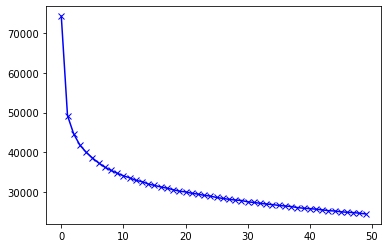

In [ ]:
# рассчитаем сразу несколько возможных количеств кластеров для выбора оптимального
n_clusters = 500               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1,n_clusters, 10): # Пробегаем по списку от 1 до n_clusters
  kmean = KMeans(i)           # Создаем объект KMeans с i-классами
  kmean.fit(data01)   # Проводим классетризацию 
  cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
  
# inertia_ - это среднее растояние от точек до центров их классов
# Может использоваться для подбора оптимального количества классов 

# Отобразим значения списка cost на графике
plt.plot(cost, 'bx-')
plt.show()

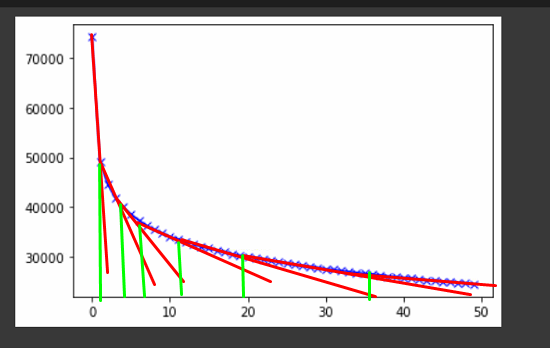

Наблюдая, количество кластеров, когда инерция изменяла свое направление, можно определеить варианты оптимального количества кластеров для текущей базы.
Получаем, что оптимально делить базу примерно на 10, 30, 60, 110, 190, 360 кластеров.

In [ ]:
# разобьем базу для 110 кластеров
clustersCount = 110            # Задаем количество кластеров
kmean = KMeans(clustersCount) # Создаем объект KMeans с указанным количеством кластеров
kmean.fit(data01)     # Произвдим кластеризацию данных 
labels = kmean.labels_        # Получаем метки кластеров

In [ ]:
# выведем информацию о 0 кластере
# видим, что алгоритм определил в кластер в основном документальные американские передачи про диких животных (в основном про акул)
clusterNumber = 0                              # Укажем номер кластера
movies_df.values[labels==clusterNumber,:] # Выведем информацию о кластере с указанным номером


array([[1824112, 'Спартанец', 1, 0, 0, 1072915200, nan, 'США', 'HD',
        'Законы древней Спарты были суровы: выживал сильнейший! Специальный агент секретной правительственной службы Скотт тому же самому учил рекрутов, которые хотели стать бойцами спецназа, — выживает сильнейший! Выживает тот, кто не раздумывает, когда надо нажать на спусковой крючок, и тот, кто выполняет приказ, не обсуждая его… Скотт — лучший кандидат для выполнения опаснейшего задания: он должен найти пропавшую девушку Лору Ньютон раньше, чем ее похитители поймут, что у них в руках — не просто студентка Гарвардского университета, а дочь видного американского политика. Скотт идет по следу преступников, однако в срок не укладывается, и пронырливые журналисты оповещают общественность, что студентка, известная всей стране, не появилась на лекции в университете… А через несколько часов теленовости рассказывают о найденной в океане утонувшей Лоре Ньютон…',
        'R18', 6.12, 6.5, 'Боевики',
        'Актёр,Актёр,Актёр

In [ ]:
# выведем фильмы из 50 кластера
# видим что в кластер попали передачи Россия 1
clusterNumber = 50                             # Укажем номер кластера
movies_df.values[labels==clusterNumber,:]

array([[1092508, '«Смерть Сталина» - не «Матильда». И новости Sundance',
        295, 0, 0, 1514764800, 'Передачи', 'Россия', 'HD',
        'Это совершенно бесспойлерный обзор фильма «Смерть Сталина» - настолько бесспойлерный, что из него вы даже не узнаете, умер ли Сталин! А начнем с новостей с фестиваля Sundance, на котором мы будем работать всю неделю.',
        'R18', 0.0, 0.0, 'Увлечения', 'Актёр,Режиссёр',
        'Москвитин  Егор,Москвитин  Егор', nan, nan],
       [1117235,
        'Хайп, игрострой и правдоподобный ствол: общаемся с создателями главной российской игры!',
        2115, 0, 0, 1514764800, 'Передачи', 'Россия', 'HD',
        'Привет, друзья! Вы соскучились по российским играм? Вот лично я очень. Само собой я говорю про классные, большие игры, за которые не стыдно ни разработчику ни игроку. И как наконец-то, спустя почти полгода я смог добиться интервью с разработчиками как раз такой игры- Escape From Tarkov от BattleState Games.. \r\nИзначально хотел в рамках проек

In [ ]:
# выведем фильмы из 100 кластера
# видим что в кластер попали отечественные художественные фильмы о войне
clusterNumber = 100                            # Укажем номер кластера
movies_df.values[labels==clusterNumber,:]

array([[1884490, 'Офицеры', 5460, ...,
        'Василий  Лановой,Наталья  Рычагова,Алина  Покровская,Георгий  Юматов,Александр  Воеводин,Владимир  Роговой',
        'Новый диск', '8'],
       [2039990, 'Во власти золота', 5616, ..., nan, nan, nan],
       [1884468, 'Веселые ребята', 5640, ...,
        'Любовь Петровна Орлова,Елена  Тяпкина,Мария  Стрелкова,Леонид  Утёсов,Мария  Иванова,Григорий  Александров',
        'Новый диск', '8'],
       ...,
       [545986, 'Арсенал', 5279, ...,
        'Семён  Свашенко,Георгий  Хорьков,Дмитрий  Эрдман,Сергей  Петров,Лучиано  Альбертини,Николай  Надемский,Николай  Кучинский,Осип  Мерлатти,Александр  Довженко,Игорь  Бэлза,Александр  Довженко,Александр  Довженко,Даниил  Демуцкий',
        'Восстание,Драма,Военный,ВУФКУ,Х/ф', '2,9,9,8,11'],
       [346510, 'Смешные люди!', 5747, ...,
        'Олег  Басилашвили,Владимир  Басов,Альберт Леонидович Филозов,Леонид Вячеславович Куравлёв,Евгений Павлович Леонов,Авангард  Леонтьев,Вячеслав  Невинный,Борис 

In [ ]:
# выведем фильмы из 20 кластера
# видим что в кластер попали в основном зарубежное фэнтези
clusterNumber = 20                            # Укажем номер кластера
movies_df.values[labels==clusterNumber,:]

array([[1881591, 'Варкрафт', 7081, ...,
        'Бен  Фостер,Тоби  Кеббелл,Доминик  Купер,Трэвис  Фиммел,Пола  Пэттон,Дункан  Джонс',
        nan, nan],
       [2044428, 'Валериан и город тысячи планет', 7879, ...,
        'Клайв  Оуэн,Кара  Делевинь,Дэйн  ДеХаан,Итан  Хоук,Люк  Бессон,Александр  Деспла,Жан-Клод  Мезьер,Пьер  Кристин,Люк  Бессон,Виржини  Силла,Люк  Бессон,Фанни  Бессон,Тьерри  Арбогаст',
        nan, nan],
       [2031415, 'Белоснежка и охотник', 7316, ...,
        'Ник  Фрост,Иэн  МакШейн,Шарлиз  Терон,Сэм  Спруэлл,Рэй  Уинстон,Боб  Хоскинс,Кристен  Стюарт,Сэм  Клафлин,Эдди  Марсан,Крис  Хемсворт,Руперт  Сандерс',
        nan, nan],
       ...,
       [475790, 'Аполлон 13', 8042, ...,
        'Билл  Пэкстон,Кевин  Бейкон,Том  Хэнкс,Эд  Харрис,Гэри  Синиз,Мэри  Кейт Шеллхардт,Кэтлин  Куинлен,Эмили  Энн Ллойд,Мико  Хьюз,Макс-Эллиотт Эллиотт Слэйд,Рон  Ховард,Джеймс  Хорнер,Уильям  Бройлес мл.,Эл  Райнерт,Джим  Ловелл,Джеффри  Клюгер,Брайан  Грейзер,Майкл  Бостик,Тодд  Х

## 2.2. Парсинг базы фильмов - текстовые значения

In [ ]:
# Выкачиваем данные по описанию и тегам
def getTextData(values):
  xText = []
  
  for val in values:
    currText = ""
    if (type(val[9]) != float):
      currText += val[9]
    if (type(val[16]) != float):
      currText += " " + val[16]
    
    xText.append(currText)
  
  xText = np.array(xText)
  
  return xText

In [ ]:
# получаем базу с текстовыми полями по каждому фильму
description = getTextData(movies_df.values)

In [ ]:
description.shape

(12192,)

In [ ]:
description[10000]

'В эпоху новой экономической политики СССР, Семен Подсекальников вовсе отказался от поиска работы. Совесть ему не позволяла жить за счет тещи и жены и чтобы не быть обузой родным и близким, герой решает покончить с собой. Его решение уйти из жизни активно поддержали дружелюбные соседи по коммуналке Поиски себя,Мосфильм,Союз,По мотивам пьесы,Комедия,Х/ф'

In [ ]:
#################
#Преобразовываем текстовые данные в числовые/векторные для кластеризации
#################

maxWordsCount = 10000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(description)         # "Скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  # Вытаскиваем индексы слов для просмотра

In [ ]:
vocabularyItems = tokenizer.word_index      # Наш словарь
print( 'Фрагмент словаря : {}'.format(list(tokenizer.word_index.items())[:50]))

Фрагмент словаря : [('unknown', 1), ('и', 2), ('в', 3), ('на', 4), ('с', 5), ('не', 6), ('но', 7), ('что', 8), ('он', 9), ('его', 10), ('ф', 11), ('х', 12), ('из', 13), ('по', 14), ('к', 15), ('а', 16), ('за', 17), ('о', 18), ('как', 19), ('драма', 20), ('у', 21), ('они', 22), ('для', 23), ('их', 24), ('от', 25), ('чтобы', 26), ('она', 27), ('фильм', 28), ('все', 29), ('это', 30), ('ее', 31), ('то', 32), ('когда', 33), ('комедия', 34), ('жизнь', 35), ('жизни', 36), ('который', 37), ('ему', 38), ('отношения', 39), ('только', 40), ('однако', 41), ('время', 42), ('после', 43), ('так', 44), ('приключения', 45), ('однажды', 46), ('где', 47), ('со', 48), ('себя', 49), ('теперь', 50)]


In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
description_indexes = tokenizer.texts_to_sequences(description) #Обучающие тексты в индексы

In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
descr01 = tokenizer.sequences_to_matrix(description_indexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(descr01.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(descr01[0][0:100])                                   # Фрагмент набора слов в виде Bag of Words

(12192, 10000)
[0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
clustersCount = 110           # Задаем количество кластеров
kmean = KMeans(clustersCount) # Создаем объект KMeans на clustersCount-классов
kmean.fit(descr01)       # Производим кластеризацию xTrainProf01
labelsDescr = kmean.labels_    # Получаем список меток

In [ ]:
# Функция определяет ключевые слова в кластере
def printDescrCluster(x, bias, vocabulary):
  mask = np.mean(x, axis=0) > bias # Создаем маску для набора x, среднии значения которого больше bias
  mX = np.mean(x, axis=0)*100      # Получаем среднее значение для набора данных x
  words = ""                       # Создаем пустую строку
  
  for w in vocabulary:            # Проходим по всем элементам словаря
    index = vocabulary[w]         # Считываем значение очередного элемента
    if (index < mask.shape[0]):   # Если значение меньше размерности списка-маски
      if (mask[index]):           # Если в массиве-маске есть само значение
        val = round(mX[index])    # Получаем значение в процентах
        words += w + " " + str(val) + "%" + "\n" # Формируем строку вывода
  
  print(words)                    # Выводим все найденные слова

In [ ]:
for clusterNumber in range(110):                                                    # Пробегаем в цикле от 0 до 110 
  print("Размер кластера", sum(labelsDescr==clusterNumber))                          # Печатаем размер очередного кластера
  printDescrCluster(descr01[labelsDescr==clusterNumber,:], 0.8, vocabularyItems) # Получаем информацию по ключевым словам очередного кластера
  print()
  print()

Выходные данные были обрезаны до нескольких последних строк (5000).
преступный 100%
секс 100%
драка 100%
большая 100%
3 100%
шпион 100%
1 100%
борьбы 100%
точно 100%
авторитет 100%
сотни 100%
красной 100%
цирка 100%
черная 100%
игрушки 100%
психопат 100%
пустыня 100%
global 100%
друге 100%
преступностью 100%
im 100%
баре 100%
экрана 100%
коп 100%
безжалостный 100%
плохие 100%
млн 100%
пар 100%
смертельные 100%
устройство 100%
куча 100%
киллеров 100%
девчонки 100%
ловко 100%
отдел 100%



Размер кластера 14
unknown 100%
и 93%
в 100%
на 100%
что 93%
по 86%
все 100%



Размер кластера 3
unknown 100%
и 100%
в 100%
на 100%
когда 100%
жизнь 100%
свою 100%
любовь 100%
пытаются 100%
искусства 100%
изменить 100%
радио 100%
обществе 100%
обсуждают 100%
произведение 100%
спасают 100%



Размер кластера 1
unknown 100%
в 100%
с 100%
к 100%
а 100%
они 100%
их 100%
до 100%
очень 100%
друг 100%
предстоит 100%
ведь 100%
стать 100%
всегда 100%
нужно 100%
сейчас 100%
которому 100%
пытаются 100%
другу 100

## 2.3 Метрика итогов кластеризации

Для метрики разработаем свою системы оценки.
Выделим среди всей базы кейсы желательного поведения пользователей: когда был поставлен лайк, был куплен фильм, фильм был досмотрен или добавлен в избранное

Эта база целевого поведения делится на две равные части: по одной определяем кластер фильма, который, например, пользователь лайкнул. Соответственно фильмы из этого кластеры мы должны ему порекомендовать. Далее по второй базе проверяем есть ли среди лайкнутых фильмов фильмы из того же кластераа. Если есть, то это считается успешной рекомендацией, если нет - неуспешной. итоговая метрица - доля успешных рекомендаций к общему числу рекомендаций

In [ ]:
# получим базу целевых поведения
success_events = events_df[(events_df['eventtype']==15) | (events_df['eventtype']==19) | (events_df['eventtype']==11) | (events_df['eventtype']==5)]
success_events = success_events.loc[:, ['subscriberid', 'assetid']].reset_index()
success_events

,index,subscriberid,assetid
0,1,77129711,1156524
1,33,9430164,1242044
2,39,507070,1521417
3,67,11775228,1525734
4,90,77978871,1300112
...,...,...,...
767814,10236673,84754719,1528940
767815,10236720,85912714,720142407
767816,10236723,8611826,720333719
767817,10236725,80691367,1521698


In [ ]:
# разделим базу на две части
train_data, test_data = train_test_split(success_events, test_size=0.5)

In [ ]:
train_data['subscriberid'].unique().shape

(65472,)

In [ ]:
# посчитаем количество успешных и не успешных рекомендаций
pos = 0     # счетчик успешных рекомендации
negs = 0   #  счетчик неуспешных рекомендаций
n = 0       # счетчик
unique_users = train_data['subscriberid'].unique()    # уникальные пользователи
for user in unique_users:       # пробегаемся по всем уникальным пользователям
  # print(n, user)
  n +=1
  user_labels = []        # составляем список уже проверенных клаастеров (чтобы избежать повторных рекомендаций одного и того же кластера)
  for movie in train_data[train_data['subscriberid'] == user]['assetid']:    #  пробегаемся по всем фильмам пользователя из первой базы
    # print(movie)
    movie_row = movies_df[movies_df['nativeitemid']==movie]    #  получаем строку фильма в общей базе
    if movie_row.shape[0] != 0:        
      label = labels[movie_row.index[0]]       # получаем номер кластера (за основу взята кластеризация по категориальным данным на 110 кластеров)
    if label not in user_labels:      #  проверяем не был ли уже расмотрен этот кластер у этого пользователя
      user_labels.append(label)        # добавляем в список кластеров пользователя
      res = 0
      for movie_test in test_data[test_data['subscriberid'] == user]['assetid']:     # проверяем есть ли понравившиеся фильмы из второй базы у этого пользователя в том же кластере
        movie_test_row = movies_df[movies_df['nativeitemid']==movie_test]
        if movie_test_row.shape[0] != 0: 
          if labels[movie_test_row.index[0]] == label:
            res = 1
            break
      if res:            # если кластеры совпали, то рекомендация успешна
        pos +=1
      else:
        negs +=1



In [ ]:
negs

118268

In [ ]:
pos

90628

In [ ]:
# доля успешных рекомендаций
pos / (negs+pos)

0.4338426776960784

## Выводы по разделу 2

Несмотря на низкие итоговые результаты по метрике, данный подход имеет место быть в качестве дополнительного к другим методам.

На субъективную оценку кластеризация имеет свою логике: при делении на классы фильмы делились по жанрам, формату, стране происхождения. Наиболее показательным является передачи про акулы, выделенные в отдельный кластер.

Деление по текстовым данным также может быть применено. Минусами получившихся итогов кластеризации можно назвать неравномерность кластеров: кластеры варьируются от 1-2 фильмов в кластере до 500-600. Однако логика в кластеризации также наблюдается.

Причинами низких результатов по метрике можно назвать ошибки к самой методике тестирования - возможно сам по себе подход к измеренению был выбра неверно. При более глубоком изучении темы возможно будет подобрана другая механика.
Кроме этого кластеризация фильмов без оценок подразумевает, что если пользователю понравился фильм, то возможно понравится и фильмы той же категории, жанра производства. По факту это не всегда так, например, если клиенту понравился фильм про акул, не означает, что он захочет посмотреть все возможные фильмы про акул.


# 3. Применение нейронных сетей в кластеризации данных

Для данной задачи подходят следующие реализации применения нейронных сетей:
- обучение embedding слоев, которые не только переводят информацию о фильме в  многомерный вектор, но и самостоятельно группируют эти вектора по разным значениям в процессе обучения: от жанров, до страны и названий. Отличием от кластеризации без нейронныых сетей будет является то, что нейронные сети способны находить менее линейные зависимости
- применение предобученных embedding слоев к текстовой информации о фильмах. Можно применить такие предобученные модели как word2vec или bert. Предобученные эмбединги обучались на больших наборах данных и самостоятельно кластеризуют слова в многомерном пространстве. Полученную информацию можно кластеризовать используя k-mean или косинусное расстояние.
- обучение самоорганизующихся карто Кохонена. Данные сети без учителя подходят для задач кластеризации.

Применение нейронных сетей в задачах кластеризации может стать как вспомогательным для классических алгоритмов, так и самостоятельным применением. 

Разработка нейронных сетей для задач кластеризации требует дополнительного времени и выходит за рамки данной работы. 

# Итоговые выводы

Лучшие результаты были получены при системе рекомендаций на основе средний оценок пользователей и матрицы похожести. Оценка на тестовой базе в 2.27 МАЕ позволяет внедрять данную технику в практическое применение.

Однако не стоит и пренебрегать и другими результатами исследования: итоговая система должна исопльзовать комплексные расчеты и не полагаться только на одну методику.

Что дальше?
Возможными направлениями дальнейших исследований можно считать:
- применение нейронных сетей для кластеризации данных (см раздел 3)
- применение кластеризации по k-mean для векторов с учетом действий пользователь (по аналогии с задаче кластеризации корзин интернет-магазина)
- переработка системы оценок, а также метрики в примененных подходах
- объединение различных методик в одну единую систему рекомендаций

